In [8]:
from skimage import measure 
from skimage.segmentation import clear_border
import tifffile as tiff 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
import os 
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
from data_module import data_utils as dt

In [4]:
test_im  = tiff.imread('/Users/whoisv/Desktop/dna.tif', key = 1)
labels, thresh  = dt.preprocess_2d(test_im, threshold_division = 0.85)

contours = measure.find_contours(thresh)
props = measure.regionprops(labels)


***Testing skimage.measure***

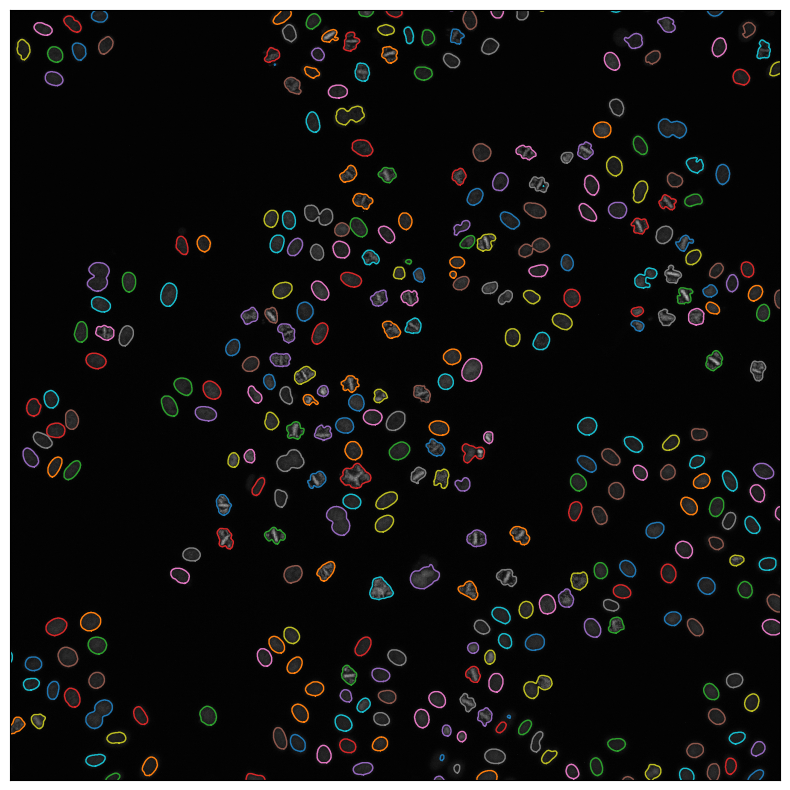

In [5]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(test_im, interpolation='nearest', cmap = plt.cm.gray)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

***Implementing skimage.measure on unprocessed ROI's***

In [6]:
def crop_regions(image_list, image_stack, box_size):
    """
    INPUTS:
           region_props: dictionary output of skimage.measure function, region_props. Must be the output of that function applied to the starting image stack
           pil_image: the same starting image, processed through the python image li|brary from cropping purposes
           box_size: 1/2 the length/width of the roi that you would like to crop

    OUTPUTS:
            regions: dictionary of cropped roi's, labeled 'Frame_i_cell_j
            discarded_box_counter: dictionary of integers, integer corresponds to the number of roi's that had to be discarded due to be 'incomplete',
            i.e. spilling out of the image
            coords: a dictionary specifying the locational coordinates (x_bottom_left, y_bottom_left) and (x_top_right, y_top_right) for each ROI
    """

    assert isinstance(box_size, int)
    assert isinstance(image_list, list)

    pil_image_dict = {}

    for i in range(image_stack.shape[0]):
        image_to_append = Image.fromarray(image_stack[i, :, :])
        pil_image_dict[f"Frame_{i}"] = image_to_append

    image_region_props = dt.preprocess_3d(image_stack)

    regions = {}
    discarded_box_counter = {}
    coords = {}
    contours = {}

    for i in range(len(list(image_region_props))):
        discarded_box_counter[f"Frame_{i}"] = 0

        for j in range(len(image_region_props[f"Frame_{i}"])):
            y, x = image_region_props[f"Frame_{i}"][j].centroid

            x1, y1 = x - box_size, y + box_size  # top left
            x2, y2 = x + box_size, y - box_size  # bottom right

            coords_temp = [x1, y1, x2, y2]

            if all(k >= 0 and k <= 2048 for k in coords_temp) == True:
                image = pil_image_dict[f"Frame_{i}"]
                region = np.array(image.crop((x1, y2, x2, y1)))
                regions[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"] = region
                coords[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"] = coords_temp

                __, thresh = dt.preprocess_2d(regions[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"], threshold_division=0.85)
                contours_relto_ROI = measure.find_contours(thresh)[0]
                countours_relto_im  = contours_relto_ROI + [coords[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"][3], #contours outputs ploygon coords as (y, x)
                                                            coords[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"][0]]
                
                contours[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"]= countours_relto_im
            else:
                discarded_box_counter[f"Frame_{i}"] += 1
            
    return regions, discarded_box_counter, image_region_props, coords, contours

In [7]:
image_stack = tiff.imread('/Users/whoisv/Desktop/dna.tif')
regions, __, __, coords, contours2 = crop_regions(['/Users/whoisv/Desktop/dna.tif'], image_stack, 42)

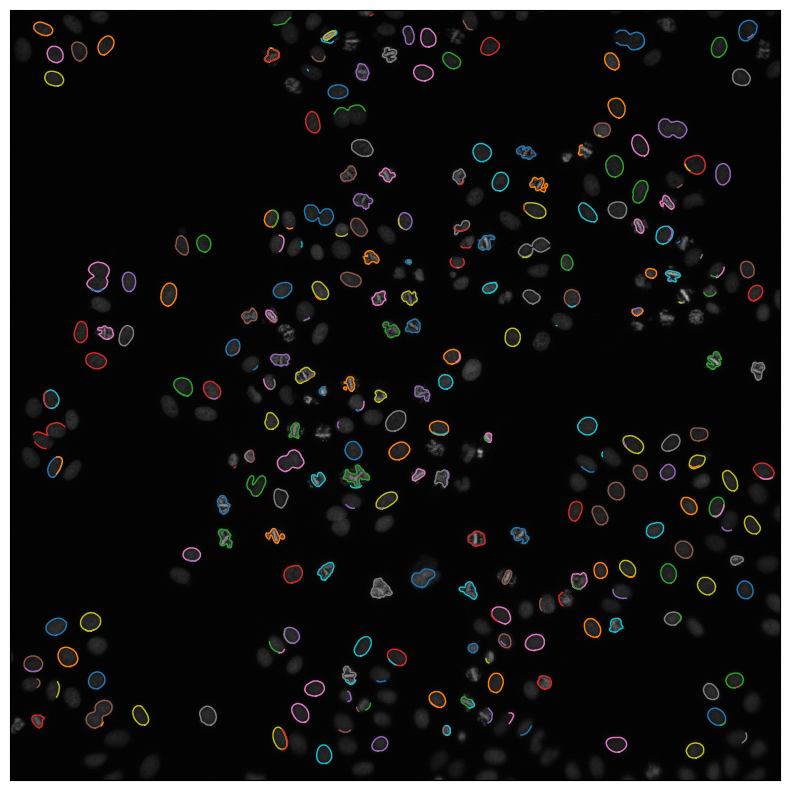

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(test_im, interpolation='nearest', cmap = plt.cm.gray)
for j in range(300):
    ax.plot(contours2[f'Frame_1_cell_{j}'][:, 1], contours2[f'Frame_1_cell_{j}'][:, 0], linewidth = 1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


***Implementing skimage.measure on cleaned ROI's***

In [9]:
props_list = props_list = ['area', 'solidity', 'perimeter_crofton', 
                           'eccentricity', 'axis_major_length','axis_minor_length', 
                           'perimeter', 'area_convex', 'area_filled', 'centroid_local', 
                           'euler_number', 'extent', 'intensity_max', 'intensity_min']

instance = dt.ROI.get(props_list,['/Users/whoisv/Desktop/dna.tif'], roi_size = 36)
instance = instance.crop()


In [31]:
contours3 = {}
discarded_box_counter_2 = {}
for i in range(instance.frame_count):
    discarded_box_counter_2[f'Frame_{i}'] = 0

    for j in range(instance.cell_count[f'Frame_{i}']):
        contours_relto_ROI_3 = measure.find_contours(instance.masks[f'Frame_{i}_cell_{j}'])
        if len(contours_relto_ROI_3) == 0:
            discarded_box_counter_2[f'Frame_{i}'] += 1
            pass
        else:
            contours_relto_im_3 = contours_relto_ROI_3[0] + [instance.coords[f'Frame_{i}_cell_{j}'][3],
                                                            instance.coords[f'Frame_{i}_cell_{j}'][0]]
        
            contours3[f"Frame_{i}_cell_{j-discarded_box_counter_2[f'Frame_{i}']}"] = contours_relto_im_3
        

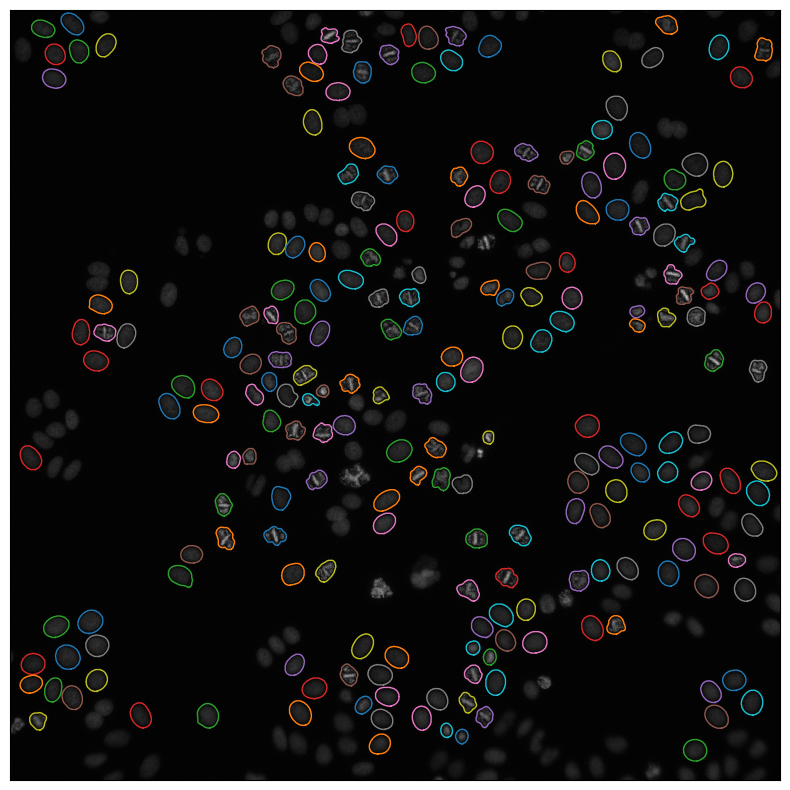

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(test_im, interpolation='nearest', cmap = plt.cm.gray)
for j in range(223):
    ax.plot(contours3[f'Frame_1_cell_{j}'][:, 1], contours3[f'Frame_1_cell_{j}'][:, 0], linewidth = 1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [11]:
def crop_regions_exp(dna_image_list, dna_image_stack, box_size, phase_image_list, phase_image_stack):
    """
    INPUTS:
           region_props: dictionary output of skimage.measure function, region_props. Must be the output of that function applied to the starting image stack
           pil_image: the same starting image, processed through the python image li|brary from cropping purposes
           box_size: 1/2 the length/width of the roi that you would like to crop

    OUTPUTS:
            regions: dictionary of cropped roi's, labeled 'Frame_i_cell_j
            discarded_box_counter: dictionary of integers, integer corresponds to the number of roi's that had to be discarded due to be 'incomplete',
            i.e. spilling out of the image
            coords: a dictionary specifying the locational coordinates (x_bottom_left, y_bottom_left) and (x_top_right, y_top_right) for each ROI
    """

    assert isinstance(box_size, int)
    assert isinstance(dna_image_list, list)
    assert isinstance(phase_image_list, list)
    assert(dna_image_stack.shape[0] == phase_image_stack.shape[0])

    pil_dna_image_dict = {}
    pil_phase_image_dict = {}

    for i in range(dna_image_stack.shape[0]):
        dna_image_to_append = Image.fromarray(dna_image_stack[i, :, :])
        pil_dna_image_dict[f"Frame_{i}"] = dna_image_to_append
        phase_image_to_append = Image.fromarray(phase_image_stack[i, :, :])
        pil_phase_image_dict[f"Frame_{i}"] = phase_image_to_append

    dna_image_region_props = dt.preprocess_3d(dna_image_stack)

    dna_regions = {}
    phase_regions ={}
    coords = {}
    discarded_box_counter = {}
    

    for i in range(len(list(dna_image_region_props))):
        discarded_box_counter[f"Frame_{i}"] = 0

        for j in range(len(dna_image_region_props[f"Frame_{i}"])):
            y, x = dna_image_region_props[f"Frame_{i}"][j].centroid

            x1, y1 = x - box_size, y + box_size  # top left
            x2, y2 = x + box_size, y - box_size  # bottom right

            coords_temp = [x1, y1, x2, y2]

            if all(k >= 0 and k <= 2048 for k in coords_temp) == True:
                dna_image = pil_dna_image_dict[f"Frame_{i}"]
                dna_region = np.array(dna_image.crop((x1, y2, x2, y1)))
                dna_regions[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"] = dna_region
                coords[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"] = coords_temp

                phase_image = pil_phase_image_dict[f"Frame_{i}"]
                phase_region = np.array(phase_image.crop((x1, y2, x2, y1)))
                phase_regions[f"Frame_{i}_cell_{j - discarded_box_counter[f'Frame_{i}']}"] = phase_region
  
            else:
                discarded_box_counter[f"Frame_{i}"] += 1

    return dna_regions, phase_regions, discarded_box_counter, dna_image_region_props, coords